In [1013]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [1014]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

In [1015]:
import statsmodels.api as sm

In [1016]:
pd.set_option('display.max_columns', 500)


In [1017]:
def get_top_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return (vif.head(1))

In [1018]:
def drop_high_vif(df, cut_off):
    high_vif_columns = []

    while True:
        top_vif = get_top_vif(X_train.drop(columns=high_vif_columns))
        if top_vif.VIF.values[0] < cut_off:
            break
        high_vif_columns.append(top_vif.Features.values[0])
    return high_vif_columns

In [1019]:
def get_high_pvals(y, X, tolerance):
    high_pvals = []
    while True:
        lm = sm.OLS(y, X.drop(columns=high_pvals)).fit()
        df_pvals = pd.DataFrame( {'Feature': lm.pvalues.index, 'pval' : np.round(lm.pvalues.values, 4)})\
           .sort_values('pval', ascending=False)
        max_pval = df_pvals.head(1).pval.values[0]
        if max_pval <= tolerance:
            break
        high_pvals.append(df_pvals.head(1).Feature.values[0])
    return high_pvals


---

# Initial Data loading the altering it in accordance to the Machine Learning

In [1020]:
df_cars = pd.read_csv('CarPrice_Assignment.csv')
df_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

#### We have no null values in the table

In [1021]:
df_cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


---
### Numerical Variable analysis

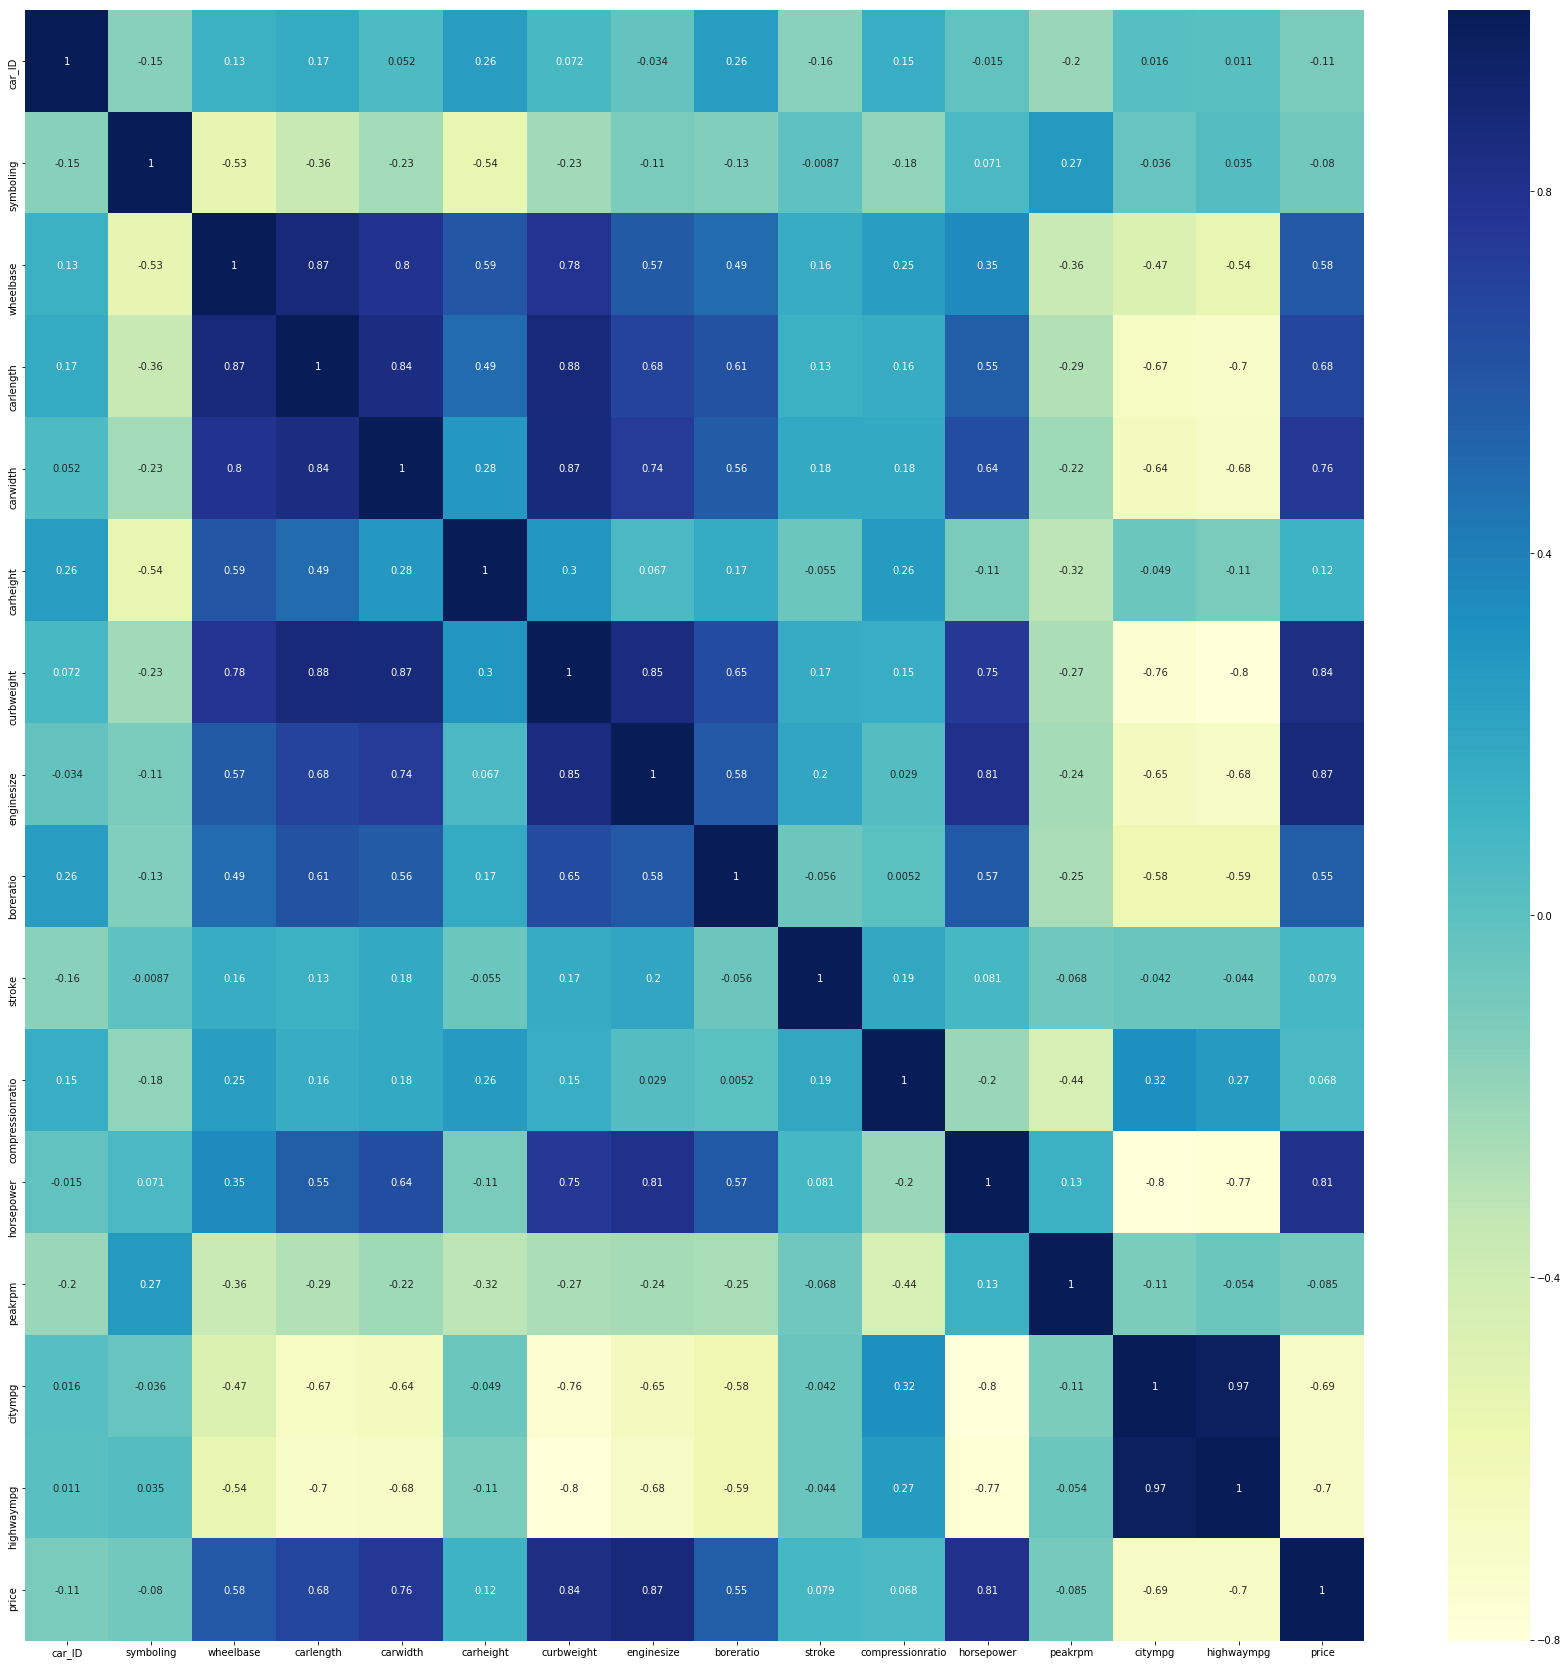

In [1022]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_cars.corr(), annot=True, cmap="YlGnBu")
plt.show()

#### The heatmap is not very clear in order to understand the correlation of numerical variables with the prices. So, I will prepare a bar chart which will show things more clearly

In [1023]:
df_corr = pd.DataFrame(df_cars.corr()['price']).reset_index()
df_corr.columns = ['Feature', 'Relation']
df_corr.sort_values(by='Relation', ascending=False, inplace=True)
df_corr = df_corr[~df_corr['Feature'].isin(['price', 'car_ID'])]

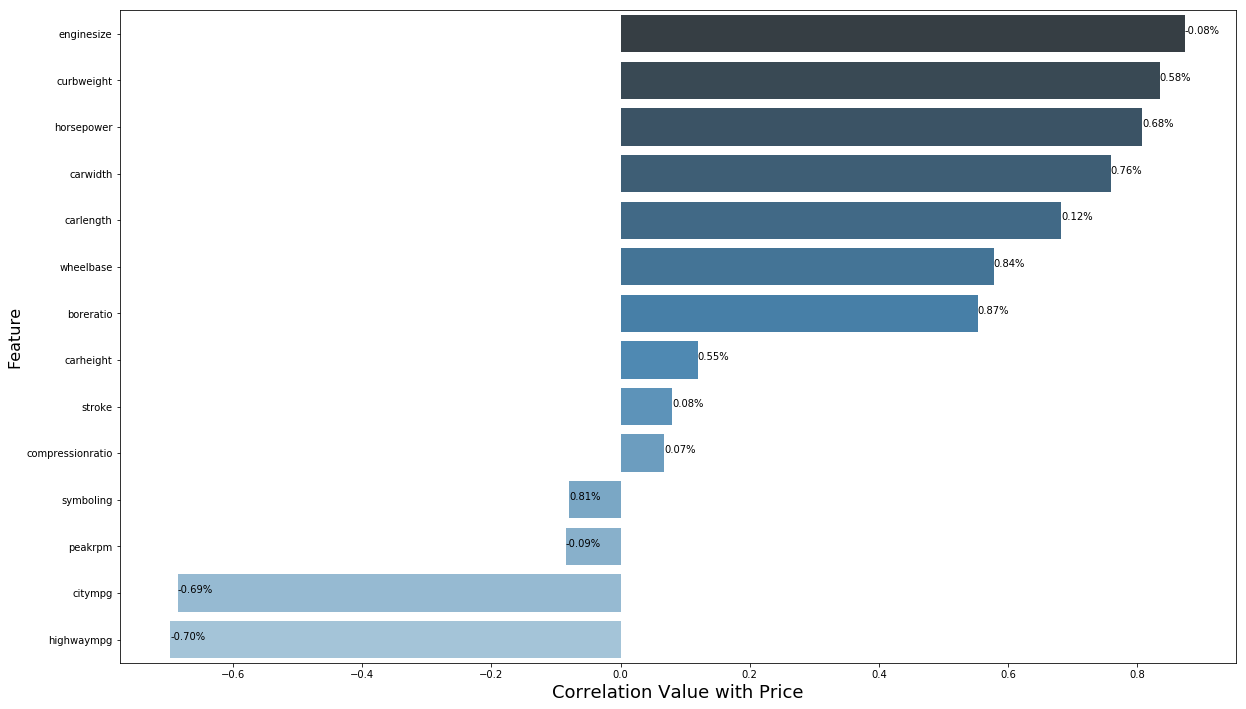

In [1024]:
plt.figure(figsize=(20, 12))
ax=sns.barplot(x='Relation', y='Feature', data=df_corr, palette='Blues_d')
i=1
for bar in ax.patches:
    value = round(df_corr.at[i, 'Relation'], 2)
    x = bar.get_x() + bar.get_width() 
    y = bar.get_y() + bar.get_height()/2
    ax.annotate('%.2f%%'%value, (x, y))    
    i += 1
plt.xlabel('Correlation Value with Price', fontsize=18)
plt.ylabel('Feature', fontsize=16)                     
plt.show()

## Inference from the correlations
The price is highly positively correlated with `enginesize`, `curbweight`, `horsepower` and highly _negatively_ correlated with `mileage` (`city` or `highway`). 

---
### Categorical Variable analysis

In [1025]:
print (df_cars.select_dtypes(object).columns) # Getting all the categorical columns
print (df_cars.select_dtypes(object).shape)

Index(['CarName', 'fueltype', 'aspiration', 'doornumber', 'carbody',
       'drivewheel', 'enginelocation', 'enginetype', 'cylindernumber',
       'fuelsystem'],
      dtype='object')
(205, 10)


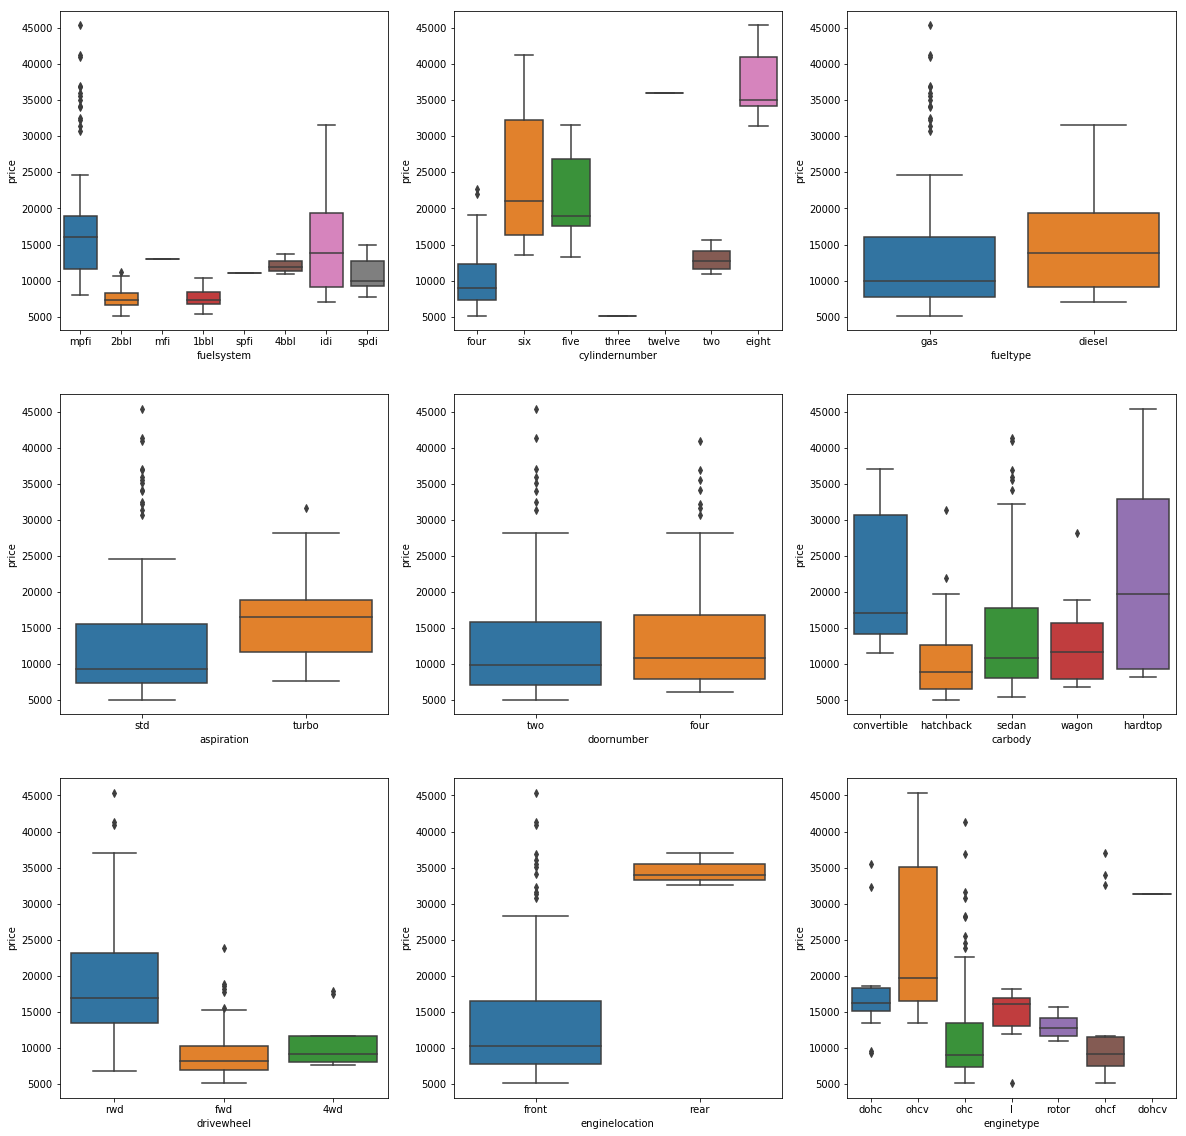

In [1066]:
plt.figure(figsize=(20, 20))
plt.subplot(3,3,1); sns.boxplot(x='fuelsystem', y='price', data=df_cars)
plt.subplot(3,3,2); sns.boxplot(x='cylindernumber', y='price', data=df_cars)
plt.subplot(3,3,3); sns.boxplot(x='fueltype', y='price', data=df_cars)
plt.subplot(3,3,4); sns.boxplot(x='aspiration', y='price', data=df_cars)
plt.subplot(3,3,5); sns.boxplot(x='doornumber', y='price', data=df_cars)
plt.subplot(3,3,6); sns.boxplot(x='carbody', y='price', data=df_cars)
plt.subplot(3,3,7); sns.boxplot(x='drivewheel', y='price', data=df_cars)
plt.subplot(3,3,8); sns.boxplot(x='enginelocation', y='price', data=df_cars)
plt.subplot(3,3,9); sns.boxplot(x='enginetype', y='price', data=df_cars)

plt.show()

## Inference from the box plots:

### `fuelsystem` 
- When the fuelsystem is mpfi or idi, the price ranges vary a lot. However the 2bbl, mfi, spfi, 4bbl and spdi are in cheaper cars

### `cylindernumber`
- There is a trend that as the cylinder numbers increase, the price keeps on increasing

### `fueltype`
- Although the diesel cars on an average are more expensive, the outliers in the petrol/gas cars go very high (and very low) in price. 

### `aspiration`
- Although the turbo cars on an average are more expensive, the outliers in the standard cars go very high (and very low) in price. 

### `doornumber`
- It doesn't have considerable effect

### `carbody`
- convertible and hardtop cars are skewed towards higher prices

### `drivewheel`
- The rear wheel drive cars are more expensive

### `enginelocation`
- The rear located engine cars are generally very expensive

### `enginetype`
- The ohcv are most expensive and ohc engine cars are least expensive

## Creating dummy variables and other extra variables

We are creating dummy variables, as in doing one hot encoding. There is no ordinality among the variable values. Hence the label encoding is not being used

In [1027]:
cat_variables = list(df_cars.select_dtypes(object).columns)        # Get all the columns which have str data
cat_variables = list(set(cat_variables) - set(['CarName']))        # except the name of the car
dummmies = pd.get_dummies(df_cars[cat_variables], drop_first=True) # prepare dummies
dummmies.head()

,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,doornumber_two,drivewheel_fwd,drivewheel_rwd,fueltype_gas,enginelocation_rear
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0
2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0
3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


####  Brand Value
There is a *brand value* which needs be utilized while creating the model. We can extract the brand name from the car's name.

In [1028]:
car_brand = df_cars['CarName'].apply(lambda x: x.split(' ')[0])
car_brand.unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

#### Many car names have typing mistakes. At least while picking their brand name, we need to fix these typos.

In [1029]:
car_brand[car_brand=='toyouta'] = 'toyota'
car_brand[car_brand.isin(['vokswagen', 'vw'])] = 'volkswagen'
car_brand[car_brand=='nissan'] = 'Nissan'
car_brand[car_brand=='maxda'] = 'mazda'
car_brand[car_brand=='porcshce'] = 'porsche'


In [1030]:
# Using one hot enconding as there is ordinality among the car brands and they are independent
car_brands=pd.get_dummies(car_brand, drop_first=True)
car_brands.head()

,alfa-romero,audi,bmw,buick,chevrolet,dodge,honda,isuzu,jaguar,mazda,mercury,mitsubishi,peugeot,plymouth,porsche,renault,saab,subaru,toyota,volkswagen,volvo
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1031]:
drop_columns=cat_variables.copy()
drop_columns.extend(['CarName', 'car_ID'])
print (drop_columns)

['fuelsystem', 'aspiration', 'carbody', 'enginetype', 'cylindernumber', 'doornumber', 'drivewheel', 'fueltype', 'enginelocation', 'CarName', 'car_ID']


---

# Model 1: Not using Brand Name
Let us see, how do the features apart from the car's brand name affect the pricing

In [1032]:
# Joining all these dummy columns to the main data set

df_cars_ready = pd.concat([df_cars, dummmies], axis=1)
df_cars_ready.drop(columns=drop_columns, inplace=True)

#### Normalizing the numerical variables using MinMaxScalar

In [1033]:
num_variables = list(df_cars_ready.select_dtypes([np.float64, np.int64]).columns)
df_cars_ready[num_variables] = mm_scaler.fit_transform(df_cars_ready[num_variables])
df_cars_ready.head()

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,fuelsystem_2bbl,fuelsystem_4bbl,fuelsystem_idi,fuelsystem_mfi,fuelsystem_mpfi,fuelsystem_spdi,fuelsystem_spfi,aspiration_turbo,carbody_hardtop,carbody_hatchback,carbody_sedan,carbody_wagon,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,doornumber_two,drivewheel_fwd,drivewheel_rwd,fueltype_gas,enginelocation_rear
0,1.0,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,0.207959,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0
1,1.0,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.262500,0.346939,0.222222,0.289474,0.282558,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0
2,0.6,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.441667,0.346939,0.166667,0.263158,0.282558,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,1,0
3,0.8,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.225000,0.551020,0.305556,0.368421,0.219254,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0
4,0.8,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.279167,0.551020,0.138889,0.157895,0.306142,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0


#### Creating the train and the test datasets

In [1034]:
df_train, df_test = train_test_split(df_cars_ready)

In [1035]:
X_train = df_train
X_train['const'] = 1
y_train = X_train.pop('price')

### The highly related fields need to be dropped. I will be keeping the cut-off at 10%. 

In [1036]:
high_vif_cols = drop_high_vif(X_train, cut_off=10)
X_train_sm = X_train.drop(columns=high_vif_cols)

### Training the model. I will check how are the parameters and also how is their significance

In [1037]:
lm_nobrand = sm.OLS(y_train, X_train_sm).fit()
lm_nobrand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              34.65
Date:                Sun, 19 Jan 2020   Prob (F-statistic):                    6.39e-45
Time:                        13:37:17   Log-Likelihood:                          134.11
No. Observations:                 153   AIC:                                     -220.2
Df Residuals:                     129   BIC:                                     -147.5
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
compressionratio          0.1195      0.036      3.283      0.001       0.047       0.192
peakrpm                   0.0233      0.048      0.486      0.628      -0.072       0.118
fuelsystem_2bbl           0.0446      0.025      1.783      0.077      -0.005       0.094
fuelsystem_4bbl           0.0272      0.158      0.172      0.863      -0.285       0.340
fuelsystem_mfi            0.1851      0.116      1.589      0.115      -0.045       0.416
fuelsystem_mpfi           0.1216      0.029      4.136      0.000       0.063       0.180
fuelsystem_spdi           0.1197      0.057      2.111      0.037       0.007       0.232
fuelsystem_spfi           0.0053      0.115      0.046      0.964      -0.223       0.233
aspiration_turbo          0.0495      0.031      1.609      0.110      -0.011       0.110
carbody_hardtop           0.1063      0.063      1.676      0.096      -0.019       0.232
carbody_hatchback         0.0004      0.028      0.015      0.988      -0.055       0.056
carbody_wagon            -0.0225      0.031     -0.718      0.474      -0.084       0.039
enginetype_dohcv          0.3759      0.114      3.305      0.001       0.151       0.601
enginetype_l             -0.0481      0.044     -1.083      0.281      -0.136       0.040
enginetype_ohcf           0.0051      0.041      0.126      0.900      -0.075       0.085
enginetype_ohcv           0.0886      0.047      1.895      0.060      -0.004       0.181
enginetype_rotor         -0.0132      0.114     -0.115      0.908      -0.239       0.213
cylindernumber_five       0.2143      0.047      4.606      0.000       0.122       0.306
cylindernumber_six        0.1010      0.040      2.530      0.013       0.022       0.180
cylindernumber_three      0.0244      0.121      0.202      0.840      -0.215       0.263
cylindernumber_twelve     0.3978      0.123      3.225      0.002       0.154       0.642
doornumber_two           -0.0483      0.028     -1.755      0.082      -0.103       0.006
drivewheel_rwd            0.1653      0.027      6.133      0.000       0.112       0.219
enginelocation_rear       0.2127      0.116      1.834      0.069      -0.017       0.442
==============================================================================
Omnibus:                       74.966   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              435.110
Skew:                           1.672   Prob(JB):                     3.29e-95
Kurtosis:                      10.554   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors i

### As can be seen that a lot of columns have a very high pvalues indicating their low significance. Now I will drop the fields one by one which have higher than 5% p value

In [1038]:
high_pvals = get_high_pvals(y_train, X_train_sm, 0.05)
X_train_sm.drop(columns=high_pvals, inplace=True)
X_train_cols = list(X_train_sm.columns)
print (high_pvals)

['carbody_hatchback', 'fuelsystem_spfi', 'enginetype_rotor', 'fuelsystem_4bbl', 'enginetype_ohcf', 'cylindernumber_three', 'peakrpm', 'carbody_wagon', 'enginetype_l', 'aspiration_turbo', 'carbody_hardtop', 'doornumber_two', 'fuelsystem_mfi', 'fuelsystem_2bbl', 'enginetype_ohcv']


### Checking the top VIF value again. It should have reduced as a lot of fields have been dropped.

In [1039]:
get_top_vif(X_train_sm)

,Features,VIF
7,drivewheel_rwd,2.43


## As expected, the correlation among the fileds is now under tolerance. I will again look at the model after dropping the high pvals fields

In [1040]:
lm_nobrand = sm.OLS(y_train, X_train_sm).fit()
lm_nobrand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.843
Model:                            OLS   Adj. R-squared (uncentered):              0.834
Method:                 Least Squares   F-statistic:                              86.14
Date:                Sun, 19 Jan 2020   Prob (F-statistic):                    1.83e-53
Time:                        13:37:17   Log-Likelihood:                          122.33
No. Observations:                 153   AIC:                                     -226.7
Df Residuals:                     144   BIC:                                     -199.4
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
compressionratio          0.1379      0.032      4.333      0.000       0.075       0.201
fuelsystem_mpfi           0.1251      0.020      6.342      0.000       0.086       0.164
fuelsystem_spdi           0.1385      0.042      3.259      0.001       0.055       0.223
enginetype_dohcv          0.3399      0.114      2.987      0.003       0.115       0.565
cylindernumber_five       0.2358      0.045      5.236      0.000       0.147       0.325
cylindernumber_six        0.1324      0.033      4.008      0.000       0.067       0.198
cylindernumber_twelve     0.4411      0.114      3.875      0.000       0.216       0.666
drivewheel_rwd            0.1616      0.023      6.986      0.000       0.116       0.207
enginelocation_rear       0.2583      0.084      3.071      0.003       0.092       0.425
==============================================================================
Omnibus:                      101.436   Durbin-Watson:                   1.788
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              980.569
Skew:                           2.223   Prob(JB):                    1.18e-213
Kurtosis:                      14.578   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1041]:
y_pred = lm_nobrand.predict(X_train_sm)
print ('The r-squared from the train data set is %0.2f' % r2_score(y_train, y_pred))

The r-squared from the train data set is 0.68


## All the fields are under 5% pvals and there is very low correlation among the fields. 

The $Adjusted R^2$ value is about 70%+ which is good. 

### Listing down all the coeffecients:

In [1042]:
pd.DataFrame({'Feature': lm_nobrand.params.index, 'Coeffecient' : np.round(lm_nobrand.params.values, 4)})\
              .sort_values('Coeffecient', ascending=False)

,Feature,Coeffecient
6,cylindernumber_twelve,0.4411
3,enginetype_dohcv,0.3399
8,enginelocation_rear,0.2583
4,cylindernumber_five,0.2358
7,drivewheel_rwd,0.1616
2,fuelsystem_spdi,0.1385
0,compressionratio,0.1379
5,cylindernumber_six,0.1324
1,fuelsystem_mpfi,0.1251


## Inference: 
#### When not considering the car's brand, having 12 cylinders in a car with rear enging, the engine type as dohcv affects the price the most. Also, it helps if the number of cylinders in the engine is 5 or 6. The car being rear wheel driven has an advantage. The fuel system needs to be mpfi, the asapiration as turbo. Having a hard top negatively affects the car's price.

## Checking $R^2$ in the test dataset

In [1043]:
y_test = df_test['price']
X_test = df_test[X_train_cols]
y_test_pred = lm_nobrand.predict(X_test)

In [1044]:
print (y_test.head())

55     0.144655
136    0.323519
33     0.035028
131    0.118589
91     0.038007
Name: price, dtype: float64


In [1045]:
print (y_test_pred.head())

55     0.182289
136    0.142383
33     0.018958
131    0.139797
91     0.020681
dtype: float64


In [1046]:
print ('The r-squared from the test data set is %0.2f' % (r2_score(y_test, y_test_pred)))

The r-squared from the test data set is 0.52


### The $R^2$ term in the test data set is only at 53% which indicates the model is unable to work properly in the test set. There seems to be a bias in the model and variance has to be introduced.

#### Plotting the predicted prices versus actual prices in the test data set

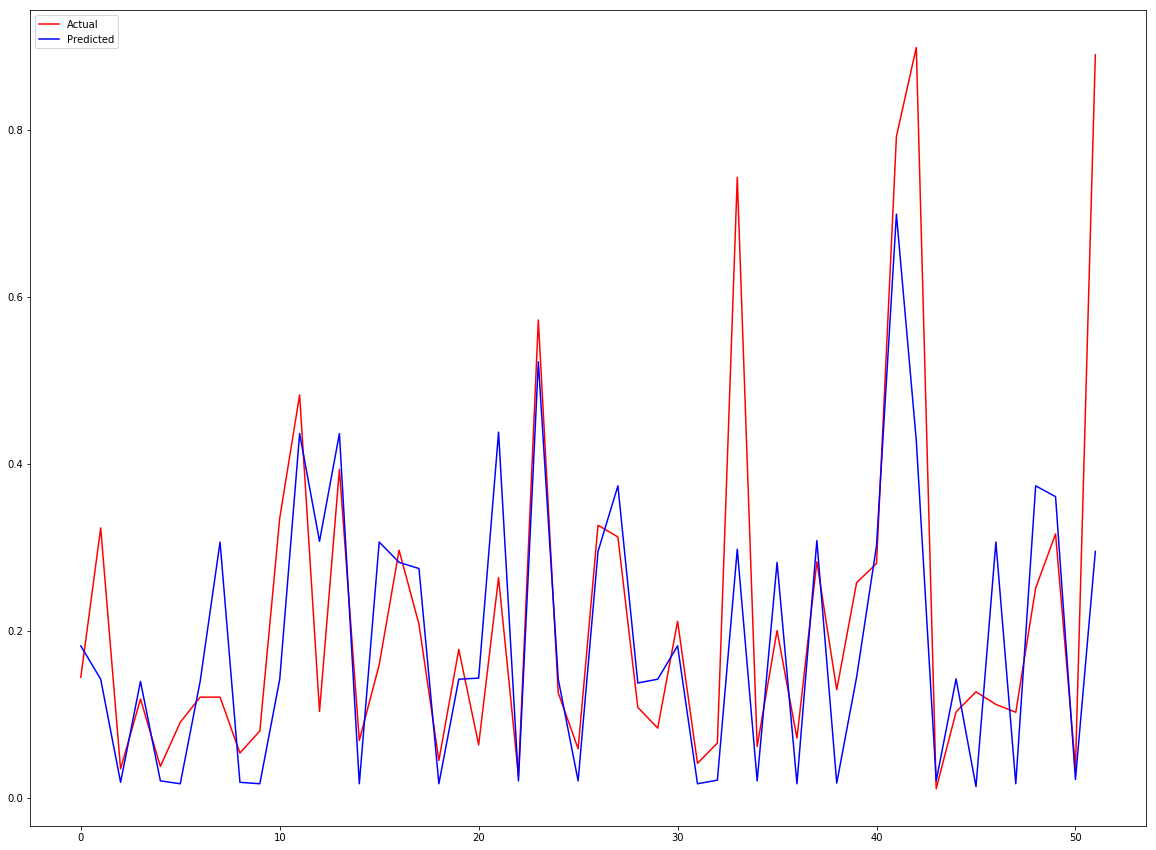

In [1047]:
plt.figure(figsize=(20, 15))
plt.plot([i for i in range (y_test.shape[0])], y_test, color='red', label='Actual')
plt.plot([i for i in range (y_test_pred.shape[0])], y_test_pred, color='blue', label='Predicted')
plt.legend(loc="upper left")
plt.show()

#### This model is unable to predict the high prices. 

---
# Model 2: Considering car's brand

In [1048]:
# Joining all these dummy columns to the main data set
df_cars_ready = pd.concat([car_brands, df_cars, dummmies], axis=1)
df_cars_ready.drop(columns=drop_columns, inplace=True)

#### Normalizing

In [1049]:
num_variables = list(df_cars_ready.select_dtypes([np.float64, np.int64]).columns)
df_cars_ready[num_variables] = mm_scaler.fit_transform(df_cars_ready[num_variables])

#### Creating the train and the test datasets

In [1050]:
df_train, df_test = train_test_split(df_cars_ready)

In [1051]:
X_train = df_train
X_train['const'] = 1
y_train = X_train.pop('price')

#### Dropped highly correlated fields

In [1052]:
high_vif_cols = drop_high_vif(X_train, cut_off=10)
X_train_sm = X_train.drop(columns=high_vif_cols)

#### Drop the fields which have higher than 5% p value

In [1053]:
high_pvals = get_high_pvals(y_train, X_train_sm, 0.05)
X_train_sm.drop(columns=high_pvals, inplace=True)
X_train_cols = list(X_train_sm.columns)

#### Checking the top VIF value again.

In [1054]:
get_top_vif(X_train_sm)

,Features,VIF
14,peakrpm,2.52


## Checking the model

In [1055]:
lm_brand = sm.OLS(y_train, X_train_sm).fit()
lm_brand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              95.84
Date:                Sun, 19 Jan 2020   Prob (F-statistic):                    2.80e-68
Time:                        13:37:29   Log-Likelihood:                          199.15
No. Observations:                 153   AIC:                                     -360.3
Df Residuals:                     134   BIC:                                     -302.7
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
alfa-romero            0.1422      0.051      2.785      0.006       0.041       0.243
audi                   0.2277      0.033      6.807      0.000       0.162       0.294
bmw                    0.3527      0.036      9.836      0.000       0.282       0.424
buick                  0.5972      0.050     11.851      0.000       0.498       0.697
jaguar                 0.4913      0.054      9.093      0.000       0.384       0.598
mazda                  0.1121      0.020      5.527      0.000       0.072       0.152
mercury                0.1588      0.072      2.200      0.030       0.016       0.302
peugeot                0.2044      0.031      6.664      0.000       0.144       0.265
porsche                0.3935      0.044      8.911      0.000       0.306       0.481
saab                   0.1588      0.043      3.722      0.000       0.074       0.243
subaru                 0.0616      0.025      2.508      0.013       0.013       0.110
toyota                 0.0703      0.016      4.506      0.000       0.039       0.101
volkswagen             0.0581      0.023      2.572      0.011       0.013       0.103
volvo                  0.1771      0.029      6.180      0.000       0.120       0.234
peakrpm                0.1279      0.020      6.385      0.000       0.088       0.168
fuelsystem_2bbl       -0.0295      0.013     -2.297      0.023      -0.055      -0.004
aspiration_turbo       0.0794      0.016      4.829      0.000       0.047       0.112
enginetype_dohcv       0.1754      0.082      2.126      0.035       0.012       0.339
cylindernumber_six     0.1919      0.022      8.897      0.000       0.149       0.235
==============================================================================
Omnibus:                       28.073   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.175
Skew:                           0.779   Prob(JB):                     3.15e-14
Kurtosis:                       5.706   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1056]:
y_pred = lm_brand.predict(X_train_sm)
print ('The r-squared from the train data set is %0.2f' % r2_score(y_train, y_pred))

The r-squared from the train data set is 0.86


## All the fields are under 5% pvals and there is very low correlation among the fields. 

The $Adjusted R^2$ value is about 90% which is excellent. 

### Listing down all the coeffecients:

In [1057]:
df_coeff = pd.DataFrame({'Feature': lm_brand.params.index, 'Coeffecient' : np.round(lm_brand.params.values, 4)})\
              .sort_values('Coeffecient', ascending=False)
df_coeff

,Feature,Coeffecient
3,buick,0.5972
4,jaguar,0.4913
8,porsche,0.3935
2,bmw,0.3527
1,audi,0.2277
7,peugeot,0.2044
18,cylindernumber_six,0.1919
13,volvo,0.1771
17,enginetype_dohcv,0.1754
9,saab,0.1588


#### Inference: Apart from the car's brand, having `12` / `6` cylinders in a car, the `dohcv` engine helps. A high `peakrpm`,   `turbo` aspiration with `mpfi` fuel system can boost a car's price. Also the hardtop in this model increases the price. 

#### In terms of branding, the company needs to follow similar strategy as being followed by `buick`, `jaguar`, `bmw`, `porsche`, `audi` etc in that sequence

## Checking $R^2$ in the test dataset

In [1058]:
y_test = df_test['price']
X_test = df_test[X_train_cols]
y_test_pred = lm_brand.predict(X_test)

In [1059]:
print ('The r-squared from the test data set is %0.2f' % (r2_score(y_test, y_test_pred)))

The r-squared from the test data set is 0.83


### Inference: The r-squared in the train and test set are not differing much hence this is a decent model to predict the car prices. 

#### Plotting the predicted versus actual prices

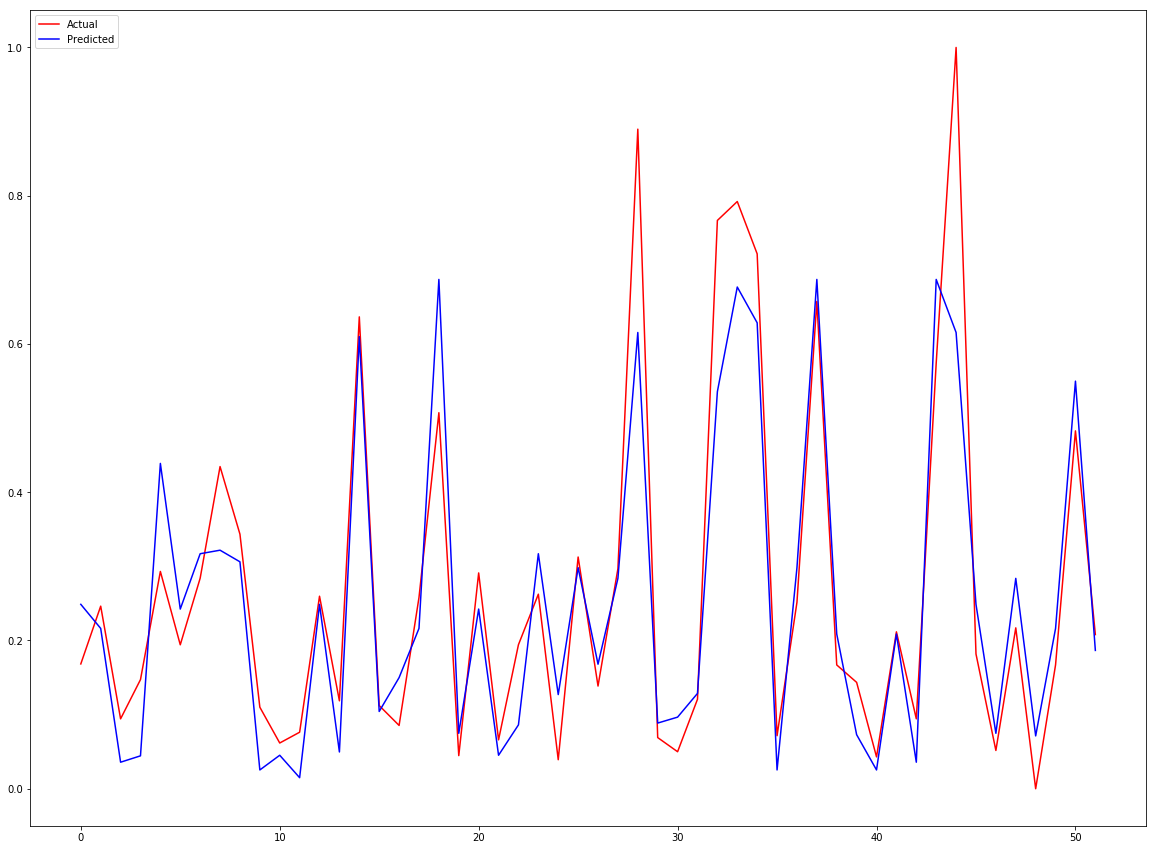

In [1060]:
plt.figure(figsize=(20, 15))
plt.plot([i for i in range (y_test.shape[0])], y_test, color='red', label='Actual')
plt.plot([i for i in range (y_test_pred.shape[0])], y_test_pred, color='blue', label='Predicted')
plt.legend(loc="upper left")
plt.show()

---
# Model 3: Lightening the Model 2
### There are 20 features in the Model 2. Let us try to lighten up the same model and remove 5 features with lowest coefficients. 

In [1061]:
drop_features = list(df_coeff.Feature.tail(5))
drop_features

['aspiration_turbo', 'toyota', 'subaru', 'volkswagen', 'fuelsystem_2bbl']

In [1062]:
X_l1 = X_train_sm.drop(columns=drop_features)
y_l1 = y_train.copy()

X_l1_test = X_test.drop(columns=drop_features)
y_l1_test = y_test.copy()

lm_light = sm.OLS(y_l1, X_l1).fit()

y_l1_pred = lm_light.predict(X_l1)
y_l1_test_pred = lm_light.predict(X_l1_test)

print ('The r2 score of the model' , round(r2_score(y_l1, y_l1_pred), 2))
print ('The r2 test score of the model',  round(r2_score(y_l1_test, y_l1_test_pred), 2))

The r2 score of the model 0.8
The r2 test score of the model 0.84


### The $R^2$ is varying a lot in the test set from the train set hence this model is not feasible. The most feasible model remains as the previous model `lm_brand`

---
## Residual Analysis

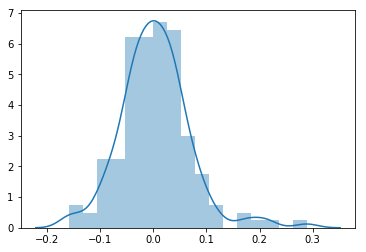

In [1063]:
# Checking the histogram
y_err = y_train - y_pred
sns.distplot(y_err)

In [1064]:
# Checking the mean of the residual terms
print ('The mean of the residual terms is %.2f' % y_err.mean())

The mean of the residual terms is 0.00


### Hence, the residual terms are distributed normally with a mean near to zero

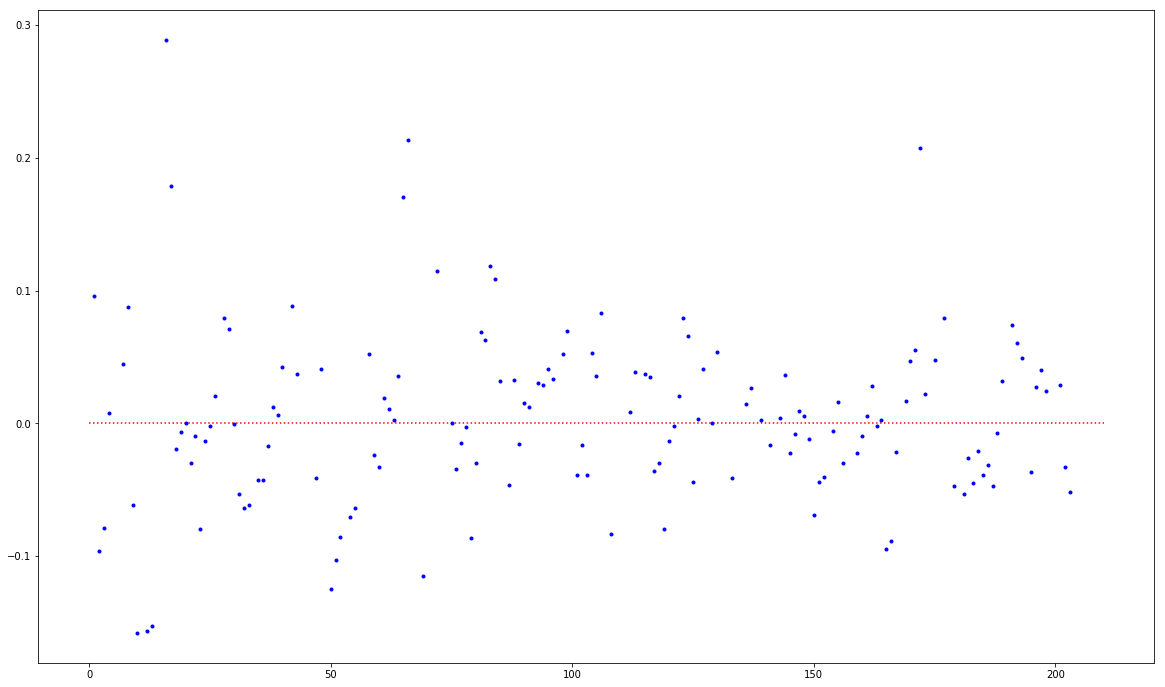

In [1065]:
# Checking 
plt.figure(figsize=(20, 12))
plt.plot(y_err, 'b.')
plt.hlines(y=0, xmin=0, xmax=210, colors='red', linestyles='dotted')
plt.show()

### The residual terms are not showing heteroscedasticity and auto correlation. Also, they are distributed randomly in a range near to 0